In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Data exploration

## 1.1 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

## 1.2 Load data

In [3]:
df = pd.read_csv("./dataset/data.csv")

## 1.3 Inspect data

We inspect the data to understand its structure, types, and any potential issues.

In [4]:
df.shape

(39942, 5)

In [5]:
df.dtypes

label       int64
title      object
text       object
subject    object
date       object
dtype: object

In [6]:
df.columns

Index(['label', 'title', 'text', 'subject', 'date'], dtype='object')

In [7]:
df.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
df.isnull().sum()

label      0
title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
df.nunique()

label          2
title      36083
text       35977
subject        6
date        2392
dtype: int64

In [10]:
df['label'].value_counts(normalize=True) * 100

label
1    50.070102
0    49.929898
Name: proportion, dtype: float64

# 2. Data cleaning

## 2.1 Reshape data

We will combine 3 columns (title, text and subject) into a single column. This is done to simplify the data structure and make it easier to work with. The new column will be called "combined_text". We will also drop the original columns (date, title, text and subject) after the reshaping process.

In [11]:
# We regroup the 3 columns into one
df['combined_text'] = df['title'] + ' ' + df['text'] + ' ' + df['subject']

In [12]:
# We drop the 3 columns
df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)

In [13]:
df.head()

,label,combined_text
0,1,"As U.S. budget fight looms, Republicans flip t..."
1,1,U.S. military to accept transgender recruits o...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,1,FBI Russia probe helped by Australian diplomat...
4,1,Trump wants Postal Service to charge 'much mor...


## 2.2 Separate y and X

We will separate the target variable (y) from the features (X). The target variable is the "label" column, which indicates whether the news article is fake or real. The features are the combined text of the articles.

In [14]:
y = df['label']
df = df.drop(['label'], axis=1)

In [15]:
df.head()

,combined_text
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...


# 3. Text preprocessing

## 3.1 Tokenization

We will tokenize the text data into a standardized format without any fluff.

In [16]:
from nltk.tokenize import word_tokenize

# We will tokenize line by line
def tokenize(text):
  return word_tokenize(text=text, language="english", preserve_line=False)
    
# We will apply the function to the column combined_text
df["tokenized_text"] = df["combined_text"].apply(tokenize)

In [17]:
df.head()

,combined_text,tokenized_text
0,"As U.S. budget fight looms, Republicans flip t...","[As, U.S., budget, fight, looms, ,, Republican..."
1,U.S. military to accept transgender recruits o...,"[U.S., military, to, accept, transgender, recr..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[Senior, U.S., Republican, senator, :, 'Let, M..."
3,FBI Russia probe helped by Australian diplomat...,"[FBI, Russia, probe, helped, by, Australian, d..."
4,Trump wants Postal Service to charge 'much mor...,"[Trump, wants, Postal, Service, to, charge, 'm..."


## 3.2 Tokenized text cleaning

- To lowercase
- Remove punctuation
- Remove stop words
- Remove numbers
- Remove extra whitespace
- Remove URLs
- Remove emojis
- Remove special characters
- Remove HTML tags
- Remove non-ASCII characters
- Remove non-alphanumeric characters
- Remove extra spaces
- Remove leading and trailing spaces

In [18]:
from nltk.corpus import stopwords
import string
import re

# Conversion en lowercase + removal ponctuation
def to_lowercase_no_punct(tokens):
  return [word.lower() for word in tokens if word.isalpha()]

# Removal stopwords
def remove_stopwords(tokens):
  stop_words = set(stopwords.words("english"))
  return [word for word in tokens if not word in stop_words]

# Removal numbers
def remove_numbers(tokens):
  return [word for word in tokens if not word.isnumeric()]

# Removal special characters
def remove_special_characters(tokens):
  return [re.sub(r'[^a-zA-Z]', '', word) for word in tokens]

# Removal extra spaces
def remove_extra_spaces(tokens):
  return [word for word in tokens if word != ' ']

# Removal accents
def remove_accents(tokens):
  return [word.encode('ascii', 'ignore').decode('utf-8') for word in tokens]

# Removal html tags
def remove_html_tags(tokens):
  return [re.sub(r'<.*?>', '', word) for word in tokens]

# Removal urls
def remove_urls(tokens):
  return [re.sub(r'http\S+|www\S+|https\S+', '', word, flags=re.MULTILINE) for word in tokens]

# Removal emojis
def remove_emojis(tokens):
  return [word.encode('ascii', 'ignore').decode('utf-8') for word in tokens]

# Apply all the functions to the column tokenized_text
def clean_text(tokens):
  tokens = to_lowercase_no_punct(tokens)
  tokens = remove_stopwords(tokens)
  tokens = remove_numbers(tokens)
  tokens = remove_special_characters(tokens)
  tokens = remove_extra_spaces(tokens)
  tokens = remove_accents(tokens)
  tokens = remove_html_tags(tokens)
  tokens = remove_urls(tokens)
  tokens = remove_emojis(tokens)
  return tokens

df["cleaned_text"] = df["tokenized_text"].apply(clean_text)

In [19]:
df.head()

,combined_text,tokenized_text,cleaned_text
0,"As U.S. budget fight looms, Republicans flip t...","[As, U.S., budget, fight, looms, ,, Republican...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,"[U.S., military, to, accept, transgender, recr...","[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[Senior, U.S., Republican, senator, :, 'Let, M...","[senior, republican, senator, mueller, job, wa..."
3,FBI Russia probe helped by Australian diplomat...,"[FBI, Russia, probe, helped, by, Australian, d...","[fbi, russia, probe, helped, australian, diplo..."
4,Trump wants Postal Service to charge 'much mor...,"[Trump, wants, Postal, Service, to, charge, 'm...","[trump, wants, postal, service, charge, amazon..."


## 3.3 Lemmatization

We will lemmatize the text data to reduce words to their base or root form. This helps in reducing the dimensionality of the data and improving the performance of the model.

In [20]:
from nltk.corpus import wordnet
from nltk import WordNetLemmatizer

# We will create a function to get the wordnet pos tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0]
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN) # returns the word type (Noun if we have not found)

# We will create a function to lemmatize the words
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

# Apply the function to the column cleaned_text
df["lemmatized_text"] = df["cleaned_text"].apply(lemmatize)

In [21]:
df.head()

,combined_text,tokenized_text,cleaned_text,lemmatized_text
0,"As U.S. budget fight looms, Republicans flip t...","[As, U.S., budget, fight, looms, ,, Republican...","[budget, fight, looms, republicans, flip, fisc...","[budget, fight, loom, republican, flip, fiscal..."
1,U.S. military to accept transgender recruits o...,"[U.S., military, to, accept, transgender, recr...","[military, accept, transgender, recruits, mond...","[military, accept, transgender, recruit, monda..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[Senior, U.S., Republican, senator, :, 'Let, M...","[senior, republican, senator, mueller, job, wa...","[senior, republican, senator, mueller, job, wa..."
3,FBI Russia probe helped by Australian diplomat...,"[FBI, Russia, probe, helped, by, Australian, d...","[fbi, russia, probe, helped, australian, diplo...","[fbi, russia, probe, help, australian, diploma..."
4,Trump wants Postal Service to charge 'much mor...,"[Trump, wants, Postal, Service, to, charge, 'm...","[trump, wants, postal, service, charge, amazon...","[trump, want, postal, service, charge, amazon,..."


# 4. Text representation (aka. vectorization)

## 4.1 TF-IDF

We will use the TF-IDF (Term Frequency-Inverse Document Frequency) method to convert the text data into numerical vectors. This method helps in representing the importance of each word in the document relative to the entire corpus.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity(x):
    return x

# We create a TfidfVectorizer. No need for the stop words since we already removed them.
tfidf_vectorizer = TfidfVectorizer(
    analyzer=identity,
    min_df=0.01,
    max_df=0.9,
    ngram_range=(1, 3), # we use trigrams because we have a lot of words
)

# We fit the vectorizer to the column lemmatized_text
tfidf_matrix = tfidf_vectorizer.fit_transform(df["lemmatized_text"])

# We create a DataFrame with the tfidf_matrix and the columns of the vectorizer
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

/Users/joachimjasmin/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


In [23]:
print("Final dictionary =>", len(tfidf_vectorizer.vocabulary_), "words")

Final dictionary => 2485 words


In [24]:
print("Dictionary =>", tfidf_vectorizer.vocabulary_)

Dictionary => {'budget': 292, 'fight': 871, 'republican': 1863, 'fiscal': 889, 'washington': 2408, 'reuters': 1894, 'head': 1024, 'conservative': 475, 'congress': 469, 'vote': 2391, 'month': 1418, 'huge': 1074, 'expansion': 813, 'national': 1445, 'debt': 583, 'pay': 1592, 'tax': 2207, 'cut': 559, 'call': 309, 'sunday': 2170, 'urge': 2355, 'keep': 1217, 'sharp': 2020, 'way': 2414, 'among': 103, 'representative': 1861, 'mark': 1343, 'speak': 2081, 'cbs': 340, 'face': 833, 'nation': 1444, 'drew': 698, 'hard': 1017, 'line': 1294, 'federal': 860, 'spending': 2090, 'lawmaker': 1254, 'battle': 211, 'january': 1186, 'return': 1893, 'holiday': 1053, 'wednesday': 2422, 'begin': 218, 'try': 2316, 'pas': 1583, 'likely': 1291, 'link': 1295, 'issue': 1181, 'immigration': 1096, 'policy': 1644, 'even': 789, 'november': 1489, 'congressional': 470, 'election': 728, 'campaign': 313, 'approach': 137, 'seek': 1982, 'control': 495, 'president': 1682, 'donald': 684, 'trump': 2313, 'want': 2402, 'big': 235, '

In [25]:
print("Top 10 words : \n")
print(tfidf_df.sum().sort_values(ascending=False).head(10))

Top 10 words : 

trump         3076.756051
say           2451.619897
state         1185.489748
president     1172.736467
republican    1060.026633
would         1040.308862
clinton        952.944198
obama          928.063223
people         908.225839
house          871.981463
dtype: float64


In [26]:
print("Last 10 words : \n")
print(tfidf_df.sum().sort_values(ascending=False).tail(10))

Last 10 words : 

fundamental    30.233001
stem           30.134656
advanced       30.044145
odds           29.604289
exclusive      29.488518
strain         29.436833
enable         29.201783
generate       28.795850
extent         27.462384
developed      26.364114
dtype: float64


In [27]:
tfidf_df.head()

,,abandon,abc,ability,able,abortion,abroad,absolute,absolutely,abuse,...,yemen,yes,yesterday,yet,york,young,youth,youtube,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.030926,0.000000,0.035472,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.071376,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.141576,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [28]:
tfidf_matrix.shape

(39942, 2485)

# 5. Model training

## 5.1 Train-test split

We will split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance.

In [29]:
from sklearn.model_selection import train_test_split

# Définition de la matrice X
# y has already been defined
X = tfidf_matrix

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 5.2 Multinomial Naive Bayes Model

We will train a Multinomial Naive Bayes Model on the training data. This model is good for text classification tasks and works well with high-dimensional data like text.

### Model training

In [30]:
# Instanciation of the model
model = MultinomialNB()

# Fitting the model
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test) # Prédit les labels sur les données de test

### Analysis - Confusion Matrix

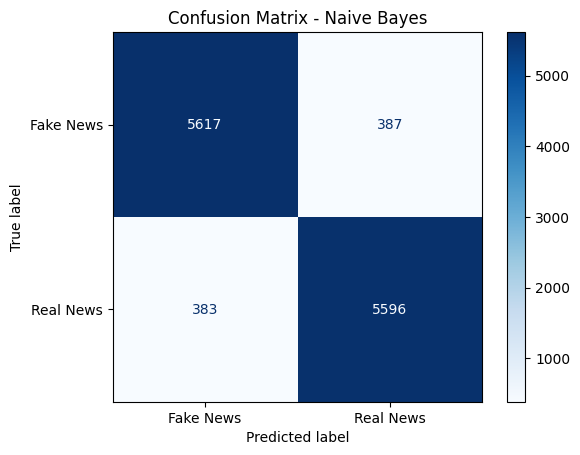

In [31]:
# Labels (1 = Real News, 0 = fake News)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake News", "Real News"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

### Analysis - ROC Curve

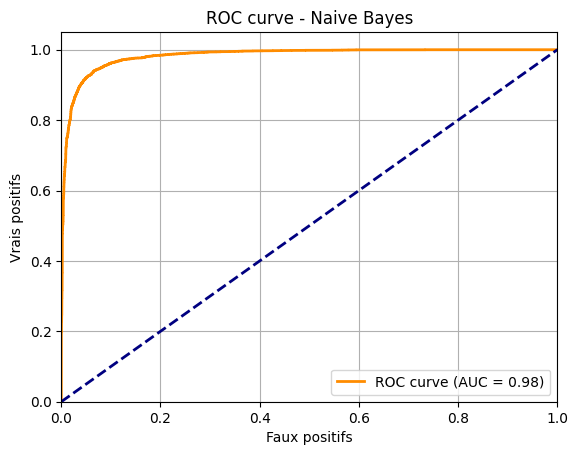

In [32]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.title("ROC curve - Naive Bayes")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Analysis - Classification Report

In [33]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, y_pred, target_names=["Fake News", "Real News"]))

              precision    recall  f1-score   support

   Fake News       0.94      0.94      0.94      6004
   Real News       0.94      0.94      0.94      5979

    accuracy                           0.94     11983
   macro avg       0.94      0.94      0.94     11983
weighted avg       0.94      0.94      0.94     11983



# 6. Model saving

In [34]:
# Save the models using pickle
import pickle

# Save the Naive Bayes model and the TfidfVectorizer
with open("naive_bayes_model_v1.pkl", "wb") as f:
    pickle.dump(model, f)

In [35]:
# Save the TfidfVectorizer
with open("tfidf_vectorizer_v1.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# 7. Model (re)loading

In [36]:
# Load the model
with open("naive_bayes_model_v1.pkl", "rb") as f:
    naive_bayes_model_v1 = pickle.load(f)

# Load the TfidfVectorizer
with open("tfidf_vectorizer_v1.pkl", "rb") as f:
    tfidf_vectorizer_v1 = pickle.load(f)

# 8. Prediction

We use the trained model to make predictions on new data. The predictions will be in the form of probabilities for each class (fake or real). We will also provide a threshold to classify the articles as fake or real based on the predicted probabilities.

## 8.1 Load new data

In [37]:
val_df = pd.read_csv("./dataset/validation_data.csv")

## 8.2 Preprocess new data

In [38]:
# We regroup the 3 columns into one
val_df['combined_text'] = val_df['title'] + ' ' + val_df['text'] + ' ' + val_df['subject']

# We drop the label column
val_df.drop(['label'], axis=1, inplace=True)

# We will tokenize line by line
val_df["tokenized_text"] = val_df["combined_text"].apply(tokenize)

# Apply all the functions to the column tokenized_text
val_df["cleaned_text"] = val_df["tokenized_text"].apply(clean_text)

# Apply the lemmatization
val_df["lemmatized_text"] = val_df["cleaned_text"].apply(lemmatize)

# We just need to transform the validation data using the same TfidfVectorizer
tfidf_matrix_val = tfidf_vectorizer_v1.transform(val_df["lemmatized_text"])

## 8.3 Predict new data

In [39]:
# Prediction
y_pred_val = naive_bayes_model_v1.predict(tfidf_matrix_val) # Prédit les labels sur les données de test

## 8.4 Write predictions to DF

In [40]:
# Add the predictions to the DataFrame
val_df["predictions_num"] = y_pred_val

# Convert the predictions to string
val_df["predictions"] = val_df["predictions_num"].replace({0: "Fake News", 1: "Real News"})

# Clean the DataFrame
val_df.drop(['combined_text', 'tokenized_text', 'cleaned_text', 'lemmatized_text', 'predictions_num'], axis=1, inplace=True)

In [43]:
val_df.head()

,title,text,subject,date,predictions
0,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017",Real News
1,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017",Real News
2,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017",Real News
3,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017",Real News
4,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017",Real News


## 8.5 Save the enhanced model and tfidf vectorizer

In [44]:
# Save the enhanced tfidf model
with open("naive_bayes_model_v2.pkl", "wb") as f:
    pickle.dump(naive_bayes_model_v1, f)
with open("tfidf_vectorizer_v2.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer_v1, f)

## 8.6 Save the predictions to a CSV file

In [45]:
# Save the predictions to a CSV file
val_df.to_csv("predictions.csv", index=False)

# Save the predictions to a JSON file
val_df.to_json("predictions.json", orient="records", lines=True) # On anticipe un fichier JSON avec une ligne par enregistrement pour communication API une fois le modèle mis en prod